In [51]:
# Load data
import pandas as pd
import numpy as np
import nltk
url = "SMSSpamCollection.txt"
df = pd.read_csv(url, sep='\t', header=None )
df.rename(columns={0:'type',1:'mail'}, inplace=True)
df


,type,mail
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [52]:
df['minuscule']=df['mail'].str.lower()
df

,type,mail,minuscule
0,ham,"Go until jurong point, crazy.. Available only ...","go until jurong point, crazy.. available only ..."
1,ham,Ok lar... Joking wif u oni...,ok lar... joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor... u c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro...","nah i don't think he goes to usf, he lives aro..."
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,this is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?,will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s...","pity, * was in mood for that. so...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...,the guy did some bitching but i acted like i'd...


In [53]:
# tokenizer avec RE (regular expressions)
from nltk.tokenize import RegexpTokenizer
nltk.download('punkt')

# tokenizer = RegexpTokenizer(r"[a-zA-Z]\w+\'?\w*")
tokenizer = RegexpTokenizer(r"\b\w+\b|\d{2} \d{2} \d{2} \d{2} \d{2}|http\S+")

df['token'] = df['minuscule'].apply(lambda x: tokenizer.tokenize(x))
df


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MOHAM\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,type,mail,minuscule,token
0,ham,"Go until jurong point, crazy.. Available only ...","go until jurong point, crazy.. available only ...","[go, until, jurong, point, crazy, available, o..."
1,ham,Ok lar... Joking wif u oni...,ok lar... joking wif u oni...,"[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f..."
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor... u c already then say...,"[u, dun, say, so, early, hor, u, c, already, t..."
4,ham,"Nah I don't think he goes to usf, he lives aro...","nah i don't think he goes to usf, he lives aro...","[nah, i, don, t, think, he, goes, to, usf, he,..."
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,this is the 2nd time we have tried 2 contact u...,"[this, is, the, 2nd, time, we, have, tried, 2,..."
5568,ham,Will ü b going to esplanade fr home?,will ü b going to esplanade fr home?,"[will, ü, b, going, to, esplanade, fr, home]"
5569,ham,"Pity, * was in mood for that. So...any other s...","pity, * was in mood for that. so...any other s...","[pity, was, in, mood, for, that, so, any, othe..."
5570,ham,The guy did some bitching but I acted like i'd...,the guy did some bitching but i acted like i'd...,"[the, guy, did, some, bitching, but, i, acted,..."


In [54]:

from nltk.corpus import stopwords
nltk.download('stopwords')
# Supprimer les stop words
stop = stopwords.words('english')

df['without_stopwords']=df['token'].apply(lambda x: [word for word in x if word not in stop])
df


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MOHAM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,type,mail,minuscule,token,without_stopwords
0,ham,"Go until jurong point, crazy.. Available only ...","go until jurong point, crazy.. available only ...","[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,ok lar... joking wif u oni...,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor... u c already then say...,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...","nah i don't think he goes to usf, he lives aro...","[nah, i, don, t, think, he, goes, to, usf, he,...","[nah, think, goes, usf, lives, around, though]"
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,this is the 2nd time we have tried 2 contact u...,"[this, is, the, 2nd, time, we, have, tried, 2,...","[2nd, time, tried, 2, contact, u, u, 750, poun..."
5568,ham,Will ü b going to esplanade fr home?,will ü b going to esplanade fr home?,"[will, ü, b, going, to, esplanade, fr, home]","[ü, b, going, esplanade, fr, home]"
5569,ham,"Pity, * was in mood for that. So...any other s...","pity, * was in mood for that. so...any other s...","[pity, was, in, mood, for, that, so, any, othe...","[pity, mood, suggestions]"
5570,ham,The guy did some bitching but I acted like i'd...,the guy did some bitching but i acted like i'd...,"[the, guy, did, some, bitching, but, i, acted,...","[guy, bitching, acted, like, interested, buyin..."


In [55]:

from nltk.stem import PorterStemmer


# stemmer notre list

stemmer = PorterStemmer()
df['PorterStemmer'] = df['without_stopwords'].apply(lambda x: [stemmer.stem(word) for word in x])
df

,type,mail,minuscule,token,without_stopwords,PorterStemmer
0,ham,"Go until jurong point, crazy.. Available only ...","go until jurong point, crazy.. available only ...","[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazi, avail, bugi, n, gre..."
1,ham,Ok lar... Joking wif u oni...,ok lar... joking wif u oni...,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin...","[free, entri, 2, wkli, comp, win, fa, cup, fin..."
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor... u c already then say...,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, earli, hor, u, c, alreadi, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...","nah i don't think he goes to usf, he lives aro...","[nah, i, don, t, think, he, goes, to, usf, he,...","[nah, think, goes, usf, lives, around, though]","[nah, think, goe, usf, live, around, though]"
...,...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,this is the 2nd time we have tried 2 contact u...,"[this, is, the, 2nd, time, we, have, tried, 2,...","[2nd, time, tried, 2, contact, u, u, 750, poun...","[2nd, time, tri, 2, contact, u, u, 750, pound,..."
5568,ham,Will ü b going to esplanade fr home?,will ü b going to esplanade fr home?,"[will, ü, b, going, to, esplanade, fr, home]","[ü, b, going, esplanade, fr, home]","[ü, b, go, esplanad, fr, home]"
5569,ham,"Pity, * was in mood for that. So...any other s...","pity, * was in mood for that. so...any other s...","[pity, was, in, mood, for, that, so, any, othe...","[pity, mood, suggestions]","[piti, mood, suggest]"
5570,ham,The guy did some bitching but I acted like i'd...,the guy did some bitching but i acted like i'd...,"[the, guy, did, some, bitching, but, i, acted,...","[guy, bitching, acted, like, interested, buyin...","[guy, bitch, act, like, interest, buy, someth,..."


In [56]:

df['clean'] = df['without_stopwords'].apply(lambda x: " ".join(x))
df

,type,mail,minuscule,token,without_stopwords,PorterStemmer,clean
0,ham,"Go until jurong point, crazy.. Available only ...","go until jurong point, crazy.. available only ...","[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazi, avail, bugi, n, gre...",go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,ok lar... joking wif u oni...,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]",ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin...","[free, entri, 2, wkli, comp, win, fa, cup, fin...",free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor... u c already then say...,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, earli, hor, u, c, alreadi, say]",u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...","nah i don't think he goes to usf, he lives aro...","[nah, i, don, t, think, he, goes, to, usf, he,...","[nah, think, goes, usf, lives, around, though]","[nah, think, goe, usf, live, around, though]",nah think goes usf lives around though
...,...,...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,this is the 2nd time we have tried 2 contact u...,"[this, is, the, 2nd, time, we, have, tried, 2,...","[2nd, time, tried, 2, contact, u, u, 750, poun...","[2nd, time, tri, 2, contact, u, u, 750, pound,...",2nd time tried 2 contact u u 750 pound prize 2...
5568,ham,Will ü b going to esplanade fr home?,will ü b going to esplanade fr home?,"[will, ü, b, going, to, esplanade, fr, home]","[ü, b, going, esplanade, fr, home]","[ü, b, go, esplanad, fr, home]",ü b going esplanade fr home
5569,ham,"Pity, * was in mood for that. So...any other s...","pity, * was in mood for that. so...any other s...","[pity, was, in, mood, for, that, so, any, othe...","[pity, mood, suggestions]","[piti, mood, suggest]",pity mood suggestions
5570,ham,The guy did some bitching but I acted like i'd...,the guy did some bitching but i acted like i'd...,"[the, guy, did, some, bitching, but, i, acted,...","[guy, bitching, acted, like, interested, buyin...","[guy, bitch, act, like, interest, buy, someth,...",guy bitching acted like interested buying some...


In [57]:

# data
import pandas as pd


# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
# Pipeline and model
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
# Score of models
from sklearn.metrics import accuracy_score
from sklearn.ensemble import StackingClassifier

# import pandas as pd
# import numpy as np
# from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler
# from sklearn.model_selection import train_test_split
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.metrics import accuracy_score
# from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer

In [58]:
df 

,type,mail,minuscule,token,without_stopwords,PorterStemmer,clean
0,ham,"Go until jurong point, crazy.. Available only ...","go until jurong point, crazy.. available only ...","[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazi, avail, bugi, n, gre...",go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,ok lar... joking wif u oni...,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]",ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin...","[free, entri, 2, wkli, comp, win, fa, cup, fin...",free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor... u c already then say...,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, earli, hor, u, c, alreadi, say]",u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...","nah i don't think he goes to usf, he lives aro...","[nah, i, don, t, think, he, goes, to, usf, he,...","[nah, think, goes, usf, lives, around, though]","[nah, think, goe, usf, live, around, though]",nah think goes usf lives around though
...,...,...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,this is the 2nd time we have tried 2 contact u...,"[this, is, the, 2nd, time, we, have, tried, 2,...","[2nd, time, tried, 2, contact, u, u, 750, poun...","[2nd, time, tri, 2, contact, u, u, 750, pound,...",2nd time tried 2 contact u u 750 pound prize 2...
5568,ham,Will ü b going to esplanade fr home?,will ü b going to esplanade fr home?,"[will, ü, b, going, to, esplanade, fr, home]","[ü, b, going, esplanade, fr, home]","[ü, b, go, esplanad, fr, home]",ü b going esplanade fr home
5569,ham,"Pity, * was in mood for that. So...any other s...","pity, * was in mood for that. so...any other s...","[pity, was, in, mood, for, that, so, any, othe...","[pity, mood, suggestions]","[piti, mood, suggest]",pity mood suggestions
5570,ham,The guy did some bitching but I acted like i'd...,the guy did some bitching but i acted like i'd...,"[the, guy, did, some, bitching, but, i, acted,...","[guy, bitching, acted, like, interested, buyin...","[guy, bitch, act, like, interest, buy, someth,...",guy bitching acted like interested buying some...


In [59]:
df['len']=df['mail'].str.len()
df['nombre_mots']=df['mail'].str.split().str.len()
df

,type,mail,minuscule,token,without_stopwords,PorterStemmer,clean,len,nombre_mots
0,ham,"Go until jurong point, crazy.. Available only ...","go until jurong point, crazy.. available only ...","[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazi, avail, bugi, n, gre...",go jurong point crazy available bugis n great ...,111,20
1,ham,Ok lar... Joking wif u oni...,ok lar... joking wif u oni...,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]",ok lar joking wif u oni,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin...","[free, entri, 2, wkli, comp, win, fa, cup, fin...",free entry 2 wkly comp win fa cup final tkts 2...,155,28
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor... u c already then say...,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, earli, hor, u, c, alreadi, say]",u dun say early hor u c already say,49,11
4,ham,"Nah I don't think he goes to usf, he lives aro...","nah i don't think he goes to usf, he lives aro...","[nah, i, don, t, think, he, goes, to, usf, he,...","[nah, think, goes, usf, lives, around, though]","[nah, think, goe, usf, live, around, though]",nah think goes usf lives around though,61,13
...,...,...,...,...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,this is the 2nd time we have tried 2 contact u...,"[this, is, the, 2nd, time, we, have, tried, 2,...","[2nd, time, tried, 2, contact, u, u, 750, poun...","[2nd, time, tri, 2, contact, u, u, 750, pound,...",2nd time tried 2 contact u u 750 pound prize 2...,160,30
5568,ham,Will ü b going to esplanade fr home?,will ü b going to esplanade fr home?,"[will, ü, b, going, to, esplanade, fr, home]","[ü, b, going, esplanade, fr, home]","[ü, b, go, esplanad, fr, home]",ü b going esplanade fr home,36,8
5569,ham,"Pity, * was in mood for that. So...any other s...","pity, * was in mood for that. so...any other s...","[pity, was, in, mood, for, that, so, any, othe...","[pity, mood, suggestions]","[piti, mood, suggest]",pity mood suggestions,57,10
5570,ham,The guy did some bitching but I acted like i'd...,the guy did some bitching but i acted like i'd...,"[the, guy, did, some, bitching, but, i, acted,...","[guy, bitching, acted, like, interested, buyin...","[guy, bitch, act, like, interest, buy, someth,...",guy bitching acted like interested buying some...,125,26


In [60]:
# Train test split

#X = df.drop(['type'], axis=1)
X = df[['clean','len','nombre_mots']]
y = df['type']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
X

,clean,len,nombre_mots
0,go jurong point crazy available bugis n great ...,111,20
1,ok lar joking wif u oni,29,6
2,free entry 2 wkly comp win fa cup final tkts 2...,155,28
3,u dun say early hor u c already say,49,11
4,nah think goes usf lives around though,61,13
...,...,...,...
5567,2nd time tried 2 contact u u 750 pound prize 2...,160,30
5568,ü b going esplanade fr home,36,8
5569,pity mood suggestions,57,10
5570,guy bitching acted like interested buying some...,125,26


In [61]:
column_text=df.columns[-1]
column_text

'nombre_mots'

In [62]:
# C'est juste un test
vectorizertest = TfidfVectorizer(analyzer='word', strip_accents ='unicode',min_df=3 )
matrix = vectorizertest.fit_transform(X_train)
matrix.shape

ValueError: After pruning, no terms remain. Try a lower min_df or a higher max_df.

In [ ]:
matrix.getmaxprint

<bound method spmatrix.getmaxprint of <3900x2066 sparse matrix of type '<class 'numpy.float64'>'
	with 27003 stored elements in Compressed Sparse Row format>>

In [ ]:

vectorizertest.get_feature_names_out() # C'est le dictionnaire

array(['00', '000', '02', ..., 'yun', 'yup', 'zed'], dtype=object)

In [ ]:
# Transformation of textual variables
transfo_text_TFid = Pipeline(steps=[
    ('bow', TfidfVectorizer(decode_error='ignore', analyzer='char_wb', ngram_range=(2, 2),strip_accents='unicode'))
])

transfo_text_CountVect = Pipeline(steps=[  
    ('bow', CountVectorizer(decode_error='ignore', analyzer='char_wb',strip_accents='unicode', ngram_range=(2, 2)))
])

# Class ColumnTransformer : apply alls steps on the whole dataset
preparation = ColumnTransformer(
    transformers=[
        ('data_clean', transfo_text_TFid , ['clean']),
        ('data',RobustScaler(), ['len','nombre_mots']),
    ])
preparation

# svc

ColumnTransformer(transformers=[('data_clean',
                                 Pipeline(steps=[('bow',
                                                  TfidfVectorizer(analyzer='char_wb',
                                                                  decode_error='ignore',
                                                                  ngram_range=(2,
                                                                               2),
                                                                  strip_accents='unicode'))]),
                                 ['clean']),
                                ('data',
                                 <class 'sklearn.preprocessing._data.RobustScaler'>,
                                 ['len', 'nombre_mots'])])

In [ ]:
# from sklearn.svm import LinearSVC
# from sklearn.pipeline import make_pipeline
# estimators = [
#      ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
#      ('svr', make_pipeline(StandardScaler(),
#                            LinearSVC(dual="auto", random_state=42)))
# ]
# classifier =StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

In [ ]:
# Creation of model : a ready to use pipeline for ML process

classifier =SVC(kernel='linear')
# classifier =LogisticRegression(C=1e5)
# classifier =ComplementNB()
# classifier = MultinomialNB()


In [63]:
model_lm = Pipeline([
    ('vectorizer', preparation),
    ('classifier', classifier)
])

In [64]:
model_lm

Pipeline(steps=[('vectorizer',
                 ColumnTransformer(transformers=[('data_clean',
                                                  Pipeline(steps=[('bow',
                                                                   TfidfVectorizer(analyzer='char_wb',
                                                                                   decode_error='ignore',
                                                                                   ngram_range=(2,
                                                                                                2),
                                                                                   strip_accents='unicode'))]),
                                                  ['clean']),
                                                 ('data',
                                                  <class 'sklearn.preprocessing._data.RobustScaler'>,
                                                  ['len', 'nombre_mots'])])),
                ('classifier', SVC(kernel='linear'))])

In [65]:
X_train

,clean,len,nombre_mots
4914,goal arsenal 4 henry 7 v liverpool 2 henry sco...,155,32
2541,said gonna snow start around 8 9 pm tonite pre...,112,22
5323,aah bless arm,26,5
5171,oh k come tomorrow,28,7
2532,happening gotten job begun registration perman...,104,17
...,...,...,...
3185,good morning pookie pie lol hope wake u,52,11
606,take care n get well soon,25,6
552,hurry weed deficient like three days,54,9
762,grandmas oh dear u still ill felt shit morning...,135,28


In [66]:

# Fit the model
model_lm.fit(X_train, y_train)

TypeError: Cannot clone object. You should provide an instance of scikit-learn estimator instead of a class.

In [ ]:
#X_test = transfo_text_TFid.transform(X_test)

In [ ]:
# Predict on test data

y_pred = model_lm.predict(X_test)

In [ ]:
# Performance of the model
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9856459330143541


In [ ]:
from sklearn.metrics import classification_report
# Afficher le rapport de classification
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         ham       0.99      1.00      0.99      1448
        spam       0.99      0.90      0.94       224

    accuracy                           0.99      1672
   macro avg       0.99      0.95      0.97      1672
weighted avg       0.99      0.99      0.99      1672



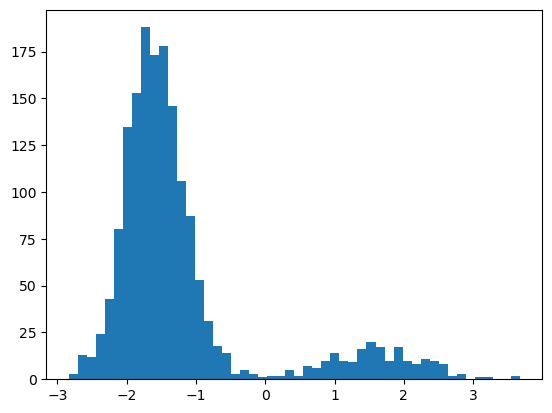

In [ ]:
import matplotlib.pyplot as plt
plt.hist(model_lm.decision_function(X_test), bins=50)
plt.show()